<h1 style="padding-top: 25px;padding-bottom: 25px;text-align: left; padding-left: 10px; background-color: #DDDDDD; 
    color: black;"> <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> AC295: Advanced Practical Data Science </h1>

## Model Compression Techniques

**Harvard University, Fall 2020**  
**Instructors**: Pavlos Protopapas  

---

**Each assignment is graded out of 5 points.  The topic for this assignment is Distillation and Pruning.**

**Due:** 11/10/2020 10:15 AM EDT

**Submit:** We won't be re running your notebooks, please ensure output is visible in the notebook.

#### Learning Objectives

In this exercise you will cover the following topics:  
- Knowledge Distillation
- Distill Teacher to Student
- Model Pruning


This exercise aims to distill a mobile-net model that has been trained initially on imagenet and then trained on vegetables images. The learned mobilenet-base model will be considered the "teacher" network. You will use distillation techniques to train a smaller, less sophisticated network that is called a "student" network. The hope is that the wisdom from the teacher network will be distilled and used. 

Then you will learn how to prune the weights of a model using the `tensorflow_model_optimization` package 

---

#### Installs

In [1]:
!pip install -q tensorflow_model_optimization

     |████████████████████████████████| 174kB 11.2MB/s 


#### Imports

In [2]:
import os
import requests
import tempfile
import zipfile
import shutil
import json
import time
import sys
import cv2
import numpy as np
import pandas as pd
from glob import glob
import subprocess
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from keras.utils.layer_utils import count_params
import tensorflow_hub as hub

import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity.keras import prune_low_magnitude

from sklearn.model_selection import train_test_split

In [3]:
def download_file(packet_url, base_path="", extract=False):
  if base_path != "":
    if not os.path.exists(base_path):
      os.mkdir(base_path)
  packet_file = os.path.basename(packet_url)
  with requests.get(packet_url, stream=True) as r:
      r.raise_for_status()
      with open(os.path.join(base_path,packet_file), 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)
  
  if extract:
    if packet_file.endswith(".zip"):
      with zipfile.ZipFile(os.path.join(base_path,packet_file)) as zfile:
        zfile.extractall(base_path)
    
    if packet_file.endswith(".tar.gz"):
      packet_name = packet_file.split('.')[0]
      with tarfile.open(os.path.join(base_path,packet_file)) as tfile:
        tfile.extractall(base_path)

# we use the following to save the models
class JsonEncoder(json.JSONEncoder):
  def default(self, obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, decimal.Decimal):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return super(JsonEncoder, self).default(obj)

# save_model saves everything. weights, statuses and results. 
def save_model(model,training_results,execution_time, learning_rate, epochs, optimizer, evaluation_results,path="models"):
  model_name=model.name
  # Get the model train history
  model_train_history = training_results.history

  # Ensure path exists
  if not os.path.exists(path):
      os.mkdir(path)

  # Save the enitire model (structure + weights)
  model.save(os.path.join(path,model_name+".hdf5"))

  # Save only the weights
  model.save_weights(os.path.join(path,model_name+".h5"))

  # Save the structure only
  model_json = model.to_json()
  with open(os.path.join(path,model_name+".json"), "w") as json_file:
      json_file.write(model_json)
    
  model_size = get_model_size(model_name=model_name)

  # Save model history
  with open(os.path.join("models",model_name+"_train_history.json"), "w") as json_file:
      json_file.write(json.dumps(model_train_history,cls=JsonEncoder))

  trainable_parameters = count_params(model.trainable_weights)
  non_trainable_parameters = count_params(model.non_trainable_weights)
  total_params = trainable_parameters + non_trainable_parameters

  # Save model metrics
  metrics ={
      "total_params":total_params,
      "execution_time":execution_time,
      "loss":evaluation_results[0],
      "accuracy":evaluation_results[1],
      "model_size":model_size,
      "learning_rate":learning_rate,
      "epochs":epochs,
      "optimizer":type(optimizer).__name__,
      "name": model_name,
      "id": int(time.time())
  }

  with open(os.path.join("models",model.name+"_metrics.json"), "w") as json_file:
      json_file.write(json.dumps(metrics,cls=JsonEncoder))

def get_model_size(path="models",model_name="model01"):
  model_size = os.stat(os.path.join(path,model_name+".hdf5")).st_size
  return model_size

def evaluate_model(model,test_data, training_results,execution_time, learning_rate, epochs, 
                   optimizer,save=True, 
                   loss_metrics=["loss","val_loss"],
                   acc_metrics=["accuracy","val_accuracy"]):
    
  # Get the model train history
  model_train_history = training_results.history
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history[loss_metrics[0]])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in loss_metrics:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()
  
  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in acc_metrics:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()
  
  # Evaluate on test data
  evaluation_results = model.evaluate(test_data, return_dict=True)
  print(evaluation_results)

  evaluation_results = [evaluation_results[loss_metrics[0]], evaluation_results[acc_metrics[0]]]
  
  if save:
      # Save model
      save_model(model,training_results,execution_time, learning_rate, epochs, optimizer, evaluation_results)
  
  return evaluation_results

## Dataset

**We will use the dataset from Exercise 4.** The dataset consists of images downloaded from Google Image search. There are 5 classes of the following labels: **'tomato', 'beetroot', 'broccoli', 'bell_pepper', 'carrot'**.  

[Link to dataset](https://github.com/shivasj/dataset-store/releases/download/v1.0/vegetables.zip)

## Question 1 : Build Teacher Model (1.0 Point)

Steps to build teacher model:
- Refer to code from Lecture Demo
- Download data & Create TF Datasets 
- Build a transfer learning model to classify vegetables. If you use the TF Hub [mobilenet](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4) and `learning_rate = 0.001` and `epochs > 30` you should easliy be able to get a validation accuracy of 85% or higher
- Ensure there is a plot of your training history

In [4]:
start_time = time.time()
download_file("https://github.com/shivasj/dataset-store/releases/download/v1.0/vegetables.zip", base_path="dataset", extract=True)
execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)

Download execution time (mins) 0.47894733349482216


In [5]:
# Load pre processed data
data_dir = "dataset/vegetables"

# Labels
label_names = os.listdir(data_dir)

# Number of unique labels
num_classes = len(label_names) 
# Create label index for easy lookup
label2index = dict((name, index) for index, name in enumerate(label_names))
index2label = dict((index, name) for index, name in enumerate(label_names))

print("Number of classes:", num_classes)
print("Labels:", label_names)

# Generate a list of labels and path to text
data_x = []
data_y = []

for label in label_names:
  text_files = os.listdir(os.path.join(data_dir,label))
  data_x.extend([os.path.join(data_dir,label,f) for f in text_files])
  data_y.extend([label for f in text_files])

# Preview
print("data_x count:",len(data_x))
print("data_y count:",len(data_y))
print(data_x[:5])
print(data_y[:5])

Number of classes: 5
Labels: ['bell_pepper', 'tomato', 'broccoli', 'beetroot', 'carrot']
data_x count: 2934
data_y count: 2934
['dataset/vegetables/bell_pepper/587.jpg', 'dataset/vegetables/bell_pepper/43.jpg', 'dataset/vegetables/bell_pepper/446.jpg', 'dataset/vegetables/bell_pepper/427.jpg', 'dataset/vegetables/bell_pepper/344.jpg']
['bell_pepper', 'bell_pepper', 'bell_pepper', 'bell_pepper', 'bell_pepper']


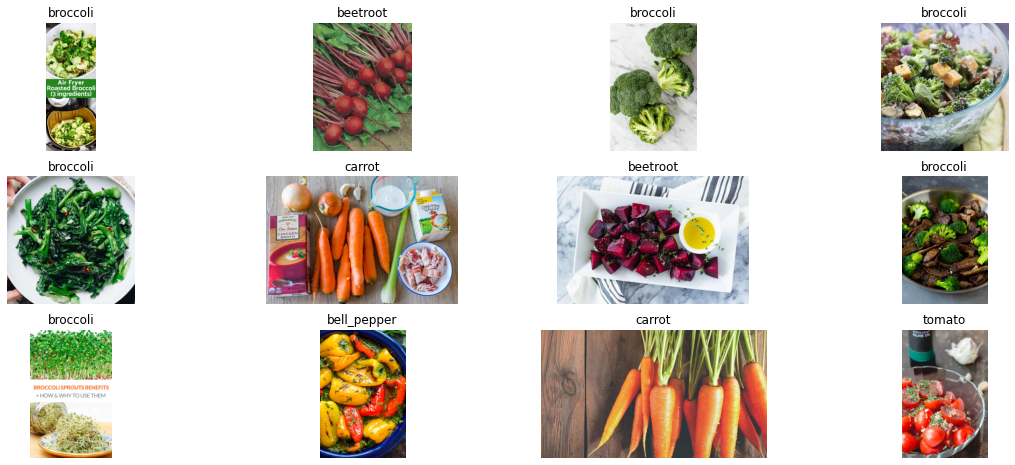

In [6]:
# View some images
image_samples = np.random.randint(0,high=len(data_x)-1, size=12)

fig = plt.figure(figsize=(20,8))
for i,img_idx in enumerate(image_samples):
    axs = fig.add_subplot(3,4,i+1)
    axs.set_title(data_y[img_idx])
    # Read image
    image = cv2.imread(data_x[img_idx])
    # convert to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')

plt.show()

In [7]:
validation_percent = 0.20

# Split data into train / validate
train_x, validate_x, train_y, validate_y = train_test_split(data_x, data_y, test_size=validation_percent)

print("train_x count:",len(train_x))
print("validate_x count:",len(validate_x))

train_x count: 2347
validate_x count: 587


In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

image_width = 224
image_height = 224
num_channels = 3
batch_size = 32
train_buffer_size = 900
validate_buffer_size = 225

# Load Image
def load_image(path, label):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=num_channels)
  image = tf.image.resize(image, [image_height,image_width])
  return image, label

# Normalize pixels
def normalize(image, label):
  image = image/255
  return image, label

# Convert all y labels to numbers
train_processed_y = [label2index[label] for label in train_y]
validate_processed_y = [label2index[label] for label in validate_y]

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_processed_y))
validation_data = tf.data.Dataset.from_tensor_slices((validate_x, validate_processed_y))

#############
# Train data
#############
# Apply all data processing logic
train_data = train_data.map(load_image, num_parallel_calls=AUTOTUNE)
train_data = train_data.map(normalize, num_parallel_calls=AUTOTUNE)
train_data = train_data.shuffle(buffer_size=train_buffer_size)
train_data = train_data.batch(batch_size)

##################
# Validation data
##################
# Apply all data processing logic
validation_data = validation_data.map(load_image, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.map(normalize, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.shuffle(buffer_size=validate_buffer_size)
validation_data = validation_data.batch(batch_size)

print("train_data",train_data)
print("validation_data",validation_data)

train_data <BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>
validation_data <BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>


In [9]:
def build_teacher_model(image_height, image_width, num_channels, num_classes):

  # Model input
  input_shape = [image_height, image_width, num_channels] # height, width, channels

  # Handle to pretrained model (Use a different model here)
  handle = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"

  # Regularize using L1
  kernel_weight = 0.02
  bias_weight = 0.02

  model = Sequential([
        layers.InputLayer(input_shape=input_shape),
                                hub.KerasLayer(handle, trainable=False),
        layers.Dense(units=64, activation='relu',
                               kernel_regularizer=regularizers.l1(kernel_weight), 
                               bias_regularizer=regularizers.l1(bias_weight)),
        layers.Dense(units=num_classes,
                                  kernel_regularizer=tf.keras.regularizers.l1(kernel_weight), 
                                  bias_regularizer=tf.keras.regularizers.l1(bias_weight))
  ],name='teacher_model')

  return model

Model: "teacher_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 64)                81984     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 2,340,293
Trainable params: 82,309
Non-trainable params: 2,257,984
_________________________________________________________________
None
Training execution time (mins) 14.49043029944102


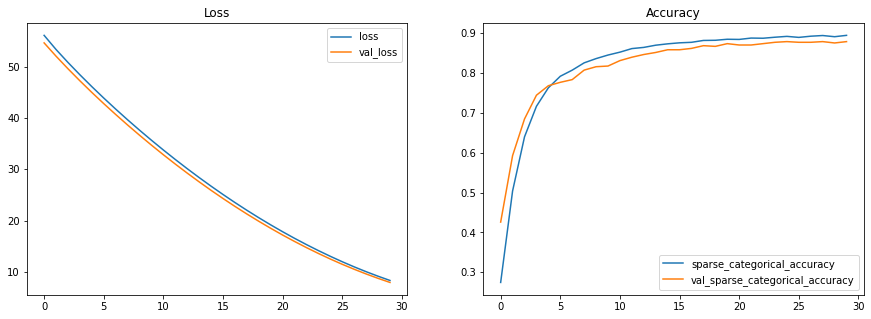

19/19 [==============================] - 4s 191ms/step - loss: 7.9300 - sparse_categorical_accuracy: 0.8790
{'loss': 7.930028438568115, 'sparse_categorical_accuracy': 0.8790460228919983}


[7.930028438568115, 0.8790460228919983]

In [10]:
############################
# Training Params
############################
learning_rate = 0.001
epochs = 30

# Free up memory
K.clear_session()

# Build the teacher model
teacher_model = build_teacher_model(image_height, image_width, num_channels, num_classes)
print(teacher_model.summary())

# Optimizer
optimizer = optimizers.SGD(lr=learning_rate)
# Loss
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
# Compile
teacher_model.compile(optimizer=optimizer,
                      loss=loss,
                      metrics=[metrics.SparseCategoricalAccuracy()])

# Train model
start_time = time.time()
training_results = teacher_model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=0)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Evaluate model
evaluate_model(teacher_model,validation_data, training_results,execution_time, 
               learning_rate, epochs, optimizer,save=True,
               loss_metrics=["loss","val_loss"],
               acc_metrics=["sparse_categorical_accuracy","val_sparse_categorical_accuracy"])

## Question 2 : Build Smaller Student Model (1.0 Point)

Steps to build teacher model:
- Refer to code from Lecture Demo
- Build a very small student model to classify vegetables. Use just 2 Convolution layers with max pooling and a dense layer
- Train the student model from scratch but use `learning_rate = 0.01` and `epochs = 10`
- Ensure there is a plot of your training history

In [11]:
def build_student_model(image_height, image_width, num_channels, num_classes, model_name='student'):
  # Model input
  input_shape = [image_height, image_width, num_channels]  # height, width, channels
  model_name =  model_name +"_"+ str(int(time.time()))



  model = Sequential(
      [
        keras.Input(shape=input_shape),
        layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),
        layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dense(units=num_classes)
      ],
      name=model_name)

  return model

Model: "student_scratch_1604848565"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 16)      448       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 112, 112, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 5)  

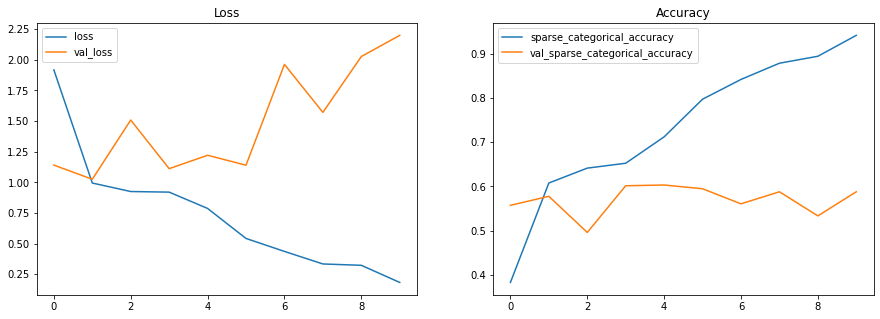

19/19 [==============================] - 3s 163ms/step - loss: 2.1994 - sparse_categorical_accuracy: 0.5877
{'loss': 2.1993563175201416, 'sparse_categorical_accuracy': 0.5877342224121094}


[2.1993563175201416, 0.5877342224121094]

In [12]:
############################
# Training Params
############################
learning_rate = 0.01
epochs = 10

# Free up memory
K.clear_session()

# Build the model
student_model_scratch = build_student_model(image_height, image_width, num_channels, num_classes, model_name='student_scratch')
print(student_model_scratch.summary())

# Optimizer
optimizer = optimizers.Adam(lr=learning_rate)
# Loss
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
# Compile
student_model_scratch.compile(optimizer=optimizer,
                      loss=loss,
                      metrics=[metrics.SparseCategoricalAccuracy()])

# Train teacher model
start_time = time.time()
training_results = student_model_scratch.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=0)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Evaluate model
evaluate_model(student_model_scratch,validation_data, training_results,execution_time, 
               learning_rate, epochs, optimizer,save=True,
               loss_metrics=["loss","val_loss"],
               acc_metrics=["sparse_categorical_accuracy","val_sparse_categorical_accuracy"])

## Question 3 : Model Distillation (1.5 Points)

Steps to distill teacher to student:
- Refer to code from Lecture Demo
- Copy the `Distiller` class over from lecture demo
- Keeping `learning_rate = 0.01` and `epochs = 10` constant, distill teacher model to student model as shown in the demo code
- You will notice there are few new parameters when you compile the `Distiller` model:
  - **Student Loss Function**: `student_loss_fn`. Set this to `tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)`
  - **Distillation Loss Function**: `distillation_loss_fn`. Set this to `tf.keras.losses.KLDivergence()`
  - **Alpha**: alpha to `student_loss_fn` and 1-alpha to `distillation_loss_fn`
  - **Temperature**: Temperature for softening probability distributions. The larger the temperature gives softer the distributions
- Try out various values for `alpha` ranging from `[0.1,0.2,0.3,0.5,1.0]`
- Try out various values for `temperature` e.g: `[1,5,10,15,30]`
- Plot the validation accuracy for the various values of `alpha` you tried
- Plot the validation accuracy for the various values of `temperature` you tried
- Pick the best `alpha` and `temperature` and train your final student model
- Ensure there is a plot of your training history of the final student model
- What are your **model size**, **total parameters**, and **accuracy** of your teacher model, student model trained with distillation, and student model trained from scratch. Feel free to use the util functions from the demo code

In [13]:
class Distiller(Model):
    def __init__(self, teacher, student):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(self,optimizer,metrics,student_loss_fn,distillation_loss_fn,alpha=0.1,temperature=3):
      """
      optimizer: Keras optimizer for the student weights
      metrics: Keras metrics for evaluation
      student_loss_fn: Loss function of difference between student predictions and ground-truth
      distillation_loss_fn: Loss function of difference between soft student predictions and soft teacher predictions
      alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
      temperature: Temperature for softening probability distributions. Larger temperature gives softer distributions.
      """
      super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
      self.student_loss_fn = student_loss_fn
      self.distillation_loss_fn = distillation_loss_fn
      self.alpha = alpha
      self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results
        

In [14]:
results = {}

In [15]:
# ############################
# # Training Params
# ############################

# learning_rate = 0.01
# epochs = 10
# alphas=[0.1,0.2,0.3,0.5,1.0]
# temperatures=[1,5,10,15,30]
# for alpha in tqdm(alphas):
#   results[alpha] = {}
#   for temperature in tqdm(temperatures):
#     # Free up memory
#     K.clear_session()

#     # Build Student model
#     student_model = build_student_model(image_height, image_width, num_channels, num_classes, model_name='student_distill')
#     print(student_model.summary())

#     # Build the distiller model
#     distiller_model = Distiller(teacher=teacher_model, student=student_model)

#     # Optimizer
#     optimizer = optimizers.Adam(lr=learning_rate)
#     # Loss
#     student_loss = losses.SparseCategoricalCrossentropy(from_logits=True)
#     distillation_loss = losses.KLDivergence()

#     # Compile
#     distiller_model.compile(
#         optimizer=optimizer,
#         student_loss_fn=student_loss,
#         distillation_loss_fn=distillation_loss,
#         metrics=[metrics.SparseCategoricalAccuracy()],
#         alpha=alpha,
#         temperature=temperature
#     )

#     # Distill teacher to student
#     start_time = time.time()
#     training_results = distiller_model.fit(
#             train_data,
#             validation_data=validation_data,
#             epochs=epochs, 
#             verbose=0)
#     execution_time = (time.time() - start_time)/60.0
#     print("Training execution time (mins)",execution_time)

#     # Evaluate model
#     evaluation_results = evaluate_model(distiller_model,validation_data, 
#                   training_results,execution_time, 
#                   learning_rate, epochs, optimizer,
#                   save=False,
#                   loss_metrics=["student_loss","distillation_loss","val_student_loss"],
#                   acc_metrics=["sparse_categorical_accuracy","val_sparse_categorical_accuracy"])

#     # Save student model
#     save_model(student_model,training_results,execution_time,learning_rate, epochs, optimizer, evaluation_results)
#     results[alpha][temperature] = evaluation_results

In [16]:
results = {0.1: {1: [1.2628655433654785, 0.5860306620597839],
  5: [0.9736211895942688, 0.5724020600318909],
  10: [0.9891775250434875, 0.5860306620597839],
  15: [0.7019230723381042, 0.5553662776947021],
  30: [0.7268065810203552, 0.5962521433830261]},
 0.2: {1: [0.9924013018608093, 0.6422487497329712],
  5: [0.5022112131118774, 0.6081771850585938],
  10: [1.0806766748428345, 0.5638841390609741],
  15: [1.8191115856170654, 0.599659264087677],
  30: [2.3576066493988037, 0.6064735651016235]},
 0.3: {1: [1.3755793571472168, 0.558773398399353],
  5: [1.1778520345687866, 0.5945485234260559],
  10: [1.0483072996139526, 0.5315161943435669],
  15: [0.41119861602783203, 0.6047700047492981],
  30: [0.7599308490753174, 0.6269165277481079]},
 0.5: {1: [1.302632212638855, 0.6201022267341614],
  5: [0.41785743832588196, 0.5860306620597839],
  10: [0.1747535765171051, 0.5962521433830261],
  15: [2.0409226417541504, 0.6132879257202148],
  30: [3.3584511280059814, 0.5621805787086487]},
 1.0: {1: [1.7377409934997559, 0.6252129673957825],
  5: [2.427332878112793, 0.6371380090713501],
  10: [2.420773506164551, 0.6064735651016235],
  15: [2.373622179031372, 0.6047700047492981],
  30: [2.915590524673462, 0.5468483567237854]}}

0.1
0.2
0.3
0.5
1.0


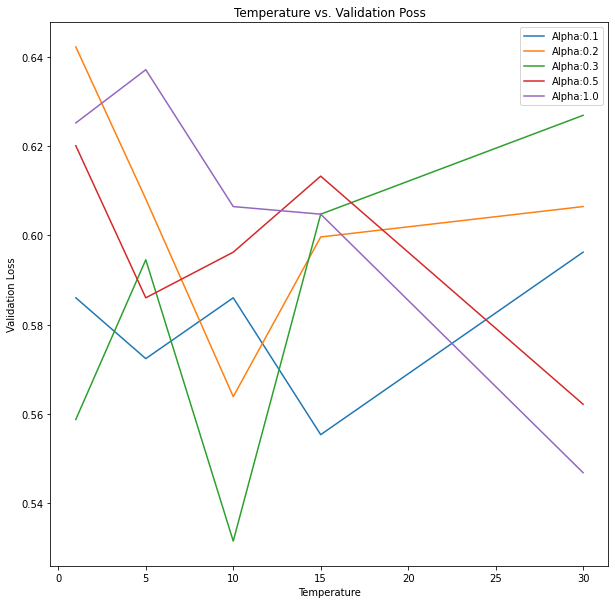

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))

for alpha in results:
  x = []
  y = []
  for temperature in results[alpha]:
    x.append(temperature)
    y.append(results[alpha][temperature][1])
  print(alpha)
  ax.plot(x, y, label='Alpha:'+str(alpha))
ax.set(xlabel='Temperature', ylabel='Validation Loss', title="Temperature vs. Validation Poss")
ax.legend()

From the plot above, we can see that the ideal Alpha = 0.2 and Temperature  = 1. I'll thus show the training of this model below. This model has 36,453 params, as you can see below

Model: "student_distill_1604849147"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 16)      448       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 112, 112, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 5)  

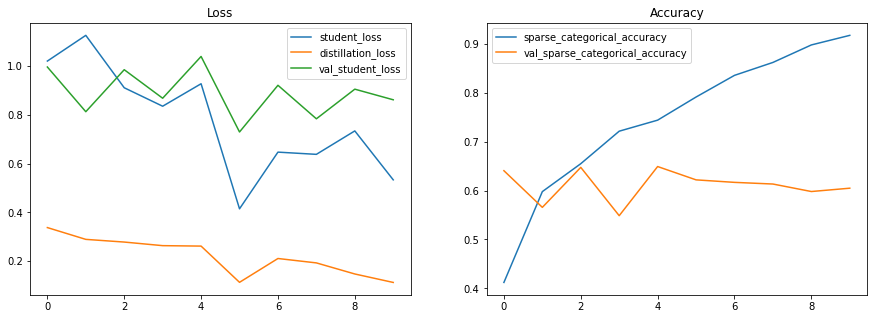

19/19 [==============================] - 3s 163ms/step - sparse_categorical_accuracy: 0.6048 - student_loss: 1.0792
{'sparse_categorical_accuracy': 0.6047700047492981, 'student_loss': 1.100986123085022}




In [21]:
############################
# Training Params
############################

learning_rate = 0.01
epochs = 10
alphas=[0.2]
temperatures=[1]
for alpha in tqdm(alphas):
  results[alpha] = {}
  for temperature in tqdm(temperatures):
    # Free up memory
    K.clear_session()

    # Build Student model
    student_model = build_student_model(image_height, image_width, num_channels, num_classes, model_name='student_distill')
    print(student_model.summary())

    # Build the distiller model
    distiller_model = Distiller(teacher=teacher_model, student=student_model)

    # Optimizer
    optimizer = optimizers.Adam(lr=learning_rate)
    # Loss
    student_loss = losses.SparseCategoricalCrossentropy(from_logits=True)
    distillation_loss = losses.KLDivergence()

    # Compile
    distiller_model.compile(
        optimizer=optimizer,
        student_loss_fn=student_loss,
        distillation_loss_fn=distillation_loss,
        metrics=[metrics.SparseCategoricalAccuracy()],
        alpha=alpha,
        temperature=temperature
    )

    # Distill teacher to student
    start_time = time.time()
    training_results = distiller_model.fit(
            train_data,
            validation_data=validation_data,
            epochs=epochs, 
            verbose=0)
    execution_time = (time.time() - start_time)/60.0
    print("Training execution time (mins)",execution_time)

    # Evaluate model
    evaluation_results = evaluate_model(distiller_model,validation_data, 
                  training_results,execution_time, 
                  learning_rate, epochs, optimizer,
                  save=False,
                  loss_metrics=["student_loss","distillation_loss","val_student_loss"],
                  acc_metrics=["sparse_categorical_accuracy","val_sparse_categorical_accuracy"])

    # Save student model
    save_model(student_model,training_results,execution_time,learning_rate, epochs, optimizer, evaluation_results)


## Question 4 : Model Pruning (1.5 Point)

In this question you will use the already trained model from the previous question and perform some weights pruning.  

Steps to perform model pruning:  
- You will use the package `tensorflow_model_optimization`, `!pip install -q tensorflow_model_optimization` which has already been included in the notebook
- For this problem you will use the student model from scratch you already trained in question 3
- Here are some helper functions to view model weights:

In [19]:
def check_model_weights(model):
  for i, w in enumerate(model.get_weights()):
    print(model.weights[i].name,"Total:",w.size, "Zeros:", round(np.sum(w == 0) / w.size * 100,2),"%")

def compare_model_sizes(model):
    _, model_file = tempfile.mkstemp(".h5")
    tf.keras.models.save_model(model, model_file, include_optimizer=False)
    _, zip3 = tempfile.mkstemp(".zip")
    with zipfile.ZipFile(zip3, "w", compression=zipfile.ZIP_DEFLATED) as f:
        f.write(model_file)
    print("Model before zipping: %.2f Kb"% (os.path.getsize(model_file) / float(1000)))
    print("Model after zipping: %.2f Kb"% (os.path.getsize(zip3) / float(1000)))


- Run `check_model_weights(...)` and `compare_model_sizes(...)` on your student model from scratch

In [22]:
# Check model before pruning
check_model_weights(student_model)
compare_model_sizes(student_model)

conv2d/kernel:0 Total: 432 Zeros: 0.0 %
conv2d/bias:0 Total: 16 Zeros: 0.0 %
conv2d_1/kernel:0 Total: 4608 Zeros: 0.0 %
conv2d_1/bias:0 Total: 32 Zeros: 0.0 %
dense/kernel:0 Total: 31360 Zeros: 0.0 %
dense/bias:0 Total: 5 Zeros: 0.0 %
Model before zipping: 164.58 Kb
Model after zipping: 138.11 Kb


- Next you will perform model pruning. For this you will need to create a wrapper model that performs the pruning. YOu can do this by passing the student model into the `prune_low_magnitude` function as shown. This is function is from the `tensorflow_model_optimization` package
- Compile the new model, `model_for_pruning` with the same optimizer and loss function that you used to train the student model from scratch
- Add a pruning callback
- Train your `model_for_pruning` model for just 2 epochs. This is enough for the wrapper model to prune weights of the the actual model

In [23]:
# Define model for pruning
epochs = 2
end_step = np.ceil(len(train_x) / batch_size).astype(np.int32) * epochs
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}
model_for_pruning = prune_low_magnitude(student_model, **pruning_params)

# Optimizer
optimizer = optimizers.Adam(lr=learning_rate)

# Loss
loss =losses.SparseCategoricalCrossentropy(from_logits=True)
# Compile model_for_pruning
model_for_pruning.compile(optimizer=optimizer,
                      loss=loss,
                      metrics=[metrics.SparseCategoricalAccuracy()])
# Callback
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep()
]

# Train
start_time = time.time()
training_results = model_for_pruning.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

Instructions for updating:
Please use `layer.add_weight` method instead.


Instructions for updating:
Please use `layer.add_weight` method instead.


Epoch 1/2
74/74 [==============================] - 20s 271ms/step - loss: 0.5293 - sparse_categorical_accuracy: 0.8155 - val_loss: 1.2058 - val_sparse_categorical_accuracy: 0.5877
Epoch 2/2
74/74 [==============================] - 20s 265ms/step - loss: 0.5670 - sparse_categorical_accuracy: 0.8010 - val_loss: 1.3682 - val_sparse_categorical_accuracy: 0.5196
Training execution time (mins) 0.9342776497205099


- Next you will need to get the student model from scratch back from the pruning wrapper. So for this you will use

In [24]:
# Get the model back after pruning
after_prune = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
after_prune.summary()

Model: "student_distill_1604849147"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 16)      448       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 112, 112, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 5)  

- Now `after_prune` is your pruned model (of the original student model from scratch)
- Run `check_model_weights(...)` and `compare_model_sizes(...)` on your pruned model
- Compare what you see from `check_model_weights(...)` on your student model from scratch vs. pruned model
- Compare what you see from `compare_model_sizes(...)` on your student model from scratch vs. pruned model

In [25]:
# Check model after pruning
check_model_weights(model_for_pruning)
compare_model_sizes(model_for_pruning)

conv2d/kernel:0 Total: 432 Zeros: 78.94 %
conv2d/bias:0 Total: 16 Zeros: 0.0 %
prune_low_magnitude_conv2d/mask:0 Total: 432 Zeros: 78.94 %
prune_low_magnitude_conv2d/threshold:0 Total: 1 Zeros: 0.0 %
prune_low_magnitude_conv2d/pruning_step:0 Total: 1 Zeros: 0.0 %
prune_low_magnitude_leaky_re_lu/pruning_step:0 Total: 1 Zeros: 0.0 %
prune_low_magnitude_max_pooling2d/pruning_step:0 Total: 1 Zeros: 0.0 %
conv2d_1/kernel:0 Total: 4608 Zeros: 78.97 %
conv2d_1/bias:0 Total: 32 Zeros: 0.0 %
prune_low_magnitude_conv2d_1/mask:0 Total: 4608 Zeros: 78.97 %
prune_low_magnitude_conv2d_1/threshold:0 Total: 1 Zeros: 0.0 %
prune_low_magnitude_conv2d_1/pruning_step:0 Total: 1 Zeros: 0.0 %
prune_low_magnitude_max_pooling2d_1/pruning_step:0 Total: 1 Zeros: 0.0 %
prune_low_magnitude_flatten/pruning_step:0 Total: 1 Zeros: 0.0 %
dense/kernel:0 Total: 31360 Zeros: 78.98 %
dense/bias:0 Total: 5 Zeros: 0.0 %
prune_low_magnitude_dense/mask:0 Total: 31360 Zeros: 78.98 %
prune_low_magnitude_dense/threshold:0 Total

As you can see, this is significatly smaller than the previous model